# Stitching code for thermography data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import SymLogNorm, LinearSegmentedColormap # -> for adjustgin illumination of each image
#import xml.etree.ElementTree as ET
import os
from natsort import natsorted # to sort the numbers in strings (s.a. path) correctly (0, 1, 2, ... instead of 0, 1, 10, ...)

In [2]:
from stitching import DataStitcher
from thermography_file_reader import ThermoFileReader
from thermography_preprocessing import ThremoDataPreprocessing, ThermoIlluminationCorrection

## Preprocessing function

In [3]:
# Preprocessing for thermography data
def thermo_preprocessing(arr, pos, new_shape, screw_part=None, transition_mask=None, *args, **kwargs):
    """
    Parameters
    ----------
        screw_type: str (default None)
            either 'shaft' or 'thread' -> for transition handling
            if unspecified, the transition files will not be separated
        transition_mask: boolean array of (8, 8) (None by default)
            This needs to be specified, if screw_type != None.
            It can be obtained via ThermoFileReader
    """
    # (0) Zip
    pos_y, pos_x = pos
    print(f'Current={pos}')
    # (1) Center the data
    proc = ThremoDataPreprocessing()
    arr_centered = proc.centering(arr)
    # (2) Remove the irrelevant part
    new_height, new_width = new_shape
    y_start = int(arr.shape[0]/2 - new_height/2)
    x_start = int(arr.shape[1]/2 - new_width/2)
    arr_trimmed = arr_centered[y_start:y_start+new_height, x_start:x_start+new_width]
    # (3) FFT phase reco
    reco = proc.reco_fft_phase(arr_trimmed)[..., 1] # seems only fbin=1 is relevant
    # Zero-mean + standardize
    mean = reco.mean()
    reco = reco - mean
    #reco /= np.abs(reco).max()
    # (4) Screw transition handling
    if (transition_mask[pos_y, pos_x] == True):
        shaft, thread = proc.separate_shaft_thred(reco)
        if screw_part == 'shaft':
            reco = shaft
        elif screw_part == 'thread':
            reco = thread
        else: # i.e. screw_part == None
            reco = np.nan_to_num(shaft) + np.nan_to_num(thread)
    # (5) Normalize for illumination adjustment (using SymLogNorm)
    # Adaptive thresholding selection
    corrector = ThermoIlluminationCorrection()
    corrector.set_parameters(
        p_start = 50.0, 
        num_bins = 401, 
        window_length = 40, 
        stepsize = 5
    )
    th = corrector.adaptive_threshold(reco)
    scale = 1.0
    norm = SymLogNorm(linthresh=th, linscale=scale, vmin=np.nanmin(reco), vmax=np.nanmax(reco), clip=False)
    #SymLogNorm(linthresh=th, linscale=scale, vmin=reco.min(), vmax=reco.max(), clip=False)
    reco_normed = norm.__call__(reco).data
    
    return reco_normed


## Parameters & setups 

In [4]:
# (4) Screws
screwNo = 78 #78, 85, 88
# Pre-damage data
#path_rel_1 = f'/Volumes/Sandisk_SD/Work/IZFP/ReMachine/Thermografie/4_InspectedSamples/B{screwNo}/measurements'
# Post-damage data
path_rel_1 = f'/Volumes/Sandisk_SD/Work/IZFP/ReMachine/Thermografie/6_SampleSet_SourceData_Nach_Belastung/B{screwNo}/measurements'


In [5]:
# Parameters: known constants 
dtype = 'uint16'
im_height, im_width = 256, 320 # actual size of each data 
frames = 73 # For stitching, we need to specify the numner of frames ---> output shape! 
# Measurement adjustment param: vertical (y-direction) offset
# The top of each measurement: we don't see anything 
# -> we can trim this area (set it to 0, to check the irrelevant area)
# currently: the offset was determined "by eyes" 
y_offset = 25 # in pixels 
xmin, xmax = 25, -25

# Data size AFTER centering and trimming each data 
seg_height = 209#im_height - y_offset
seg_width = ThremoDataPreprocessing.surface_projection(angle_start=60, angle_end=120)
seg_shape = (seg_height, seg_width, frames)

# Fidelity region ---> determined "by eyes"
fid_height = int(0.7*seg_height)
fid_width = ThremoDataPreprocessing.surface_projection(angle_start=75, angle_end=105)

# Correct width of the stitched image
nonovl_width = ThremoDataPreprocessing.surface_projection(angle_start=67.5, angle_end=135-22.5)

# Info
print(f'Segment size (w/o offset) = ({seg_height}, {seg_width})')
print(f'Fidelity region = ({fid_height}, {fid_width})')
print(f'The non-OVL area of each image = (..., {nonovl_width})')
print(f'Correct width of the stitched image = {8*nonovl_width}')

Segment size (w/o offset) = (209, 100)
Fidelity region = (146, 51)
The non-OVL area of each image = (..., 76)
Correct width of the stitched image = 608


In [6]:
run_test = False
if run_test:
    reader = ThermoFileReader(path_rel_1)
    arr_path_rel = reader.get_files(ret_structured=True)
    
    # Select the file by its position
    pos = (4, 2) # = (pos_y, pos_x)
    data_tens, fileNo = reader.load_data(
        pos=pos, 
        ymin=y_offset, 
        xmin=xmin, xmax=xmax, 
        dtype='uint16', width=320, height=256,
        ret_fileNo=True
    )
    
    print(f'fileNo={fileNo}')

## Run the Stitcher class

In [7]:
# Select which files to stitch
reader = ThermoFileReader(path_rel_1)
arr_path_rel = reader.get_files(ret_structured=True)

# Files -> depeding on the screw part
screw_part = None#'thread'

# (a) Take only the shaft
if screw_part == 'shaft':
    which_files = arr_path_rel[:5, :] #[:5, :]
    transition_mask = reader.transition_mask[:5, :]
# (b) Take only the thred
elif screw_part == 'thread':
    transition_mask = reader.transition_mask[4:, :]
    which_files = arr_path_rel[4:, :]
# (c) All files
else:
    transition_mask = reader.transition_mask
    which_files = arr_path_rel

#print('Files to stitch:')
#print(which_files)

# Number of rows and cols after stitching
numsegs_per_row = which_files.shape[0]
numsegs_per_col = which_files.shape[1]

In [8]:
stitcher = DataStitcher()
stitcher.set_parameters(
    seg_shape=seg_shape, 
    numsegs_per_row=which_files.shape[0],
    numsegs_per_col=which_files.shape[1], 
)
stitcher.segment_files = which_files
stitcher.fidelity_region= (fid_height, fid_width)

In [9]:
print(f'segment shape = {stitcher.seg_shape[:2]}')
print(f'fidelity region = ({stitcher.fid_height}, {stitcher.fid_width})')
print(f'stepsize = ({stitcher.stepsize_height}, {stitcher.stepsize_width})')

segment shape = (209, 100)
fidelity region = (145, 50)
stepsize = (177, 75)


In [10]:
output_arr = stitcher.stitch(
    func_loader=reader.load_data, 
    func_proc=thermo_preprocessing, 
    trim=False,
    normalize=False,
    weighting=True,
    y_offset=y_offset,
    xmin=xmin,
    xmax=xmax,
    new_shape=seg_shape[:2],
    screw_part=screw_part, 
    transition_mask=transition_mask
)

Current=(0, 0)
Current=(1, 0)
Current=(2, 0)
Current=(3, 0)
Current=(4, 0)
Current=(5, 0)
Current=(6, 0)
Current=(7, 0)
Current=(0, 1)
Current=(1, 1)
Current=(2, 1)
Current=(3, 1)
Current=(4, 1)
Current=(5, 1)
Current=(6, 1)
Current=(7, 1)
Current=(0, 2)
Current=(1, 2)
Current=(2, 2)
Current=(3, 2)
Current=(4, 2)
Current=(5, 2)
Current=(6, 2)
Current=(7, 2)
Current=(0, 3)
Current=(1, 3)
Current=(2, 3)
Current=(3, 3)
Current=(4, 3)
Current=(5, 3)
Current=(6, 3)
Current=(7, 3)
Current=(0, 4)
Current=(1, 4)
Current=(2, 4)
Current=(3, 4)
Current=(4, 4)
Current=(5, 4)
Current=(6, 4)
Current=(7, 4)
Current=(0, 5)
Current=(1, 5)
Current=(2, 5)
Current=(3, 5)
Current=(4, 5)
Current=(5, 5)
Current=(6, 5)
Current=(7, 5)
Current=(0, 6)
Current=(1, 6)
Current=(2, 6)
Current=(3, 6)
Current=(4, 6)
Current=(5, 6)
Current=(6, 6)
Current=(7, 6)
Current=(0, 7)
Current=(1, 7)
Current=(2, 7)
Current=(3, 7)
Current=(4, 7)
Current=(5, 7)
Current=(6, 7)
Current=(7, 7)


In [11]:
# Fidelity map
fid_map = stitcher.get_fidelity_map(ndim=output_arr.ndim, dtype=output_arr.dtype)
# Trimming
im_trimmed = stitcher.trim(output_arr)

## Plots

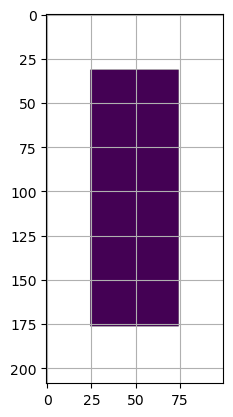

In [12]:
# Fidelity region (for each segment)
plt.imshow(stitcher.fidelity_region)
plt.grid(True)

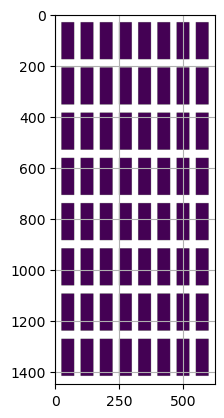

In [13]:
# Fidelity map
#stitcher.zero_mask=(0, 2)
plt.imshow(stitcher.fidelity_map)
plt.grid(True)

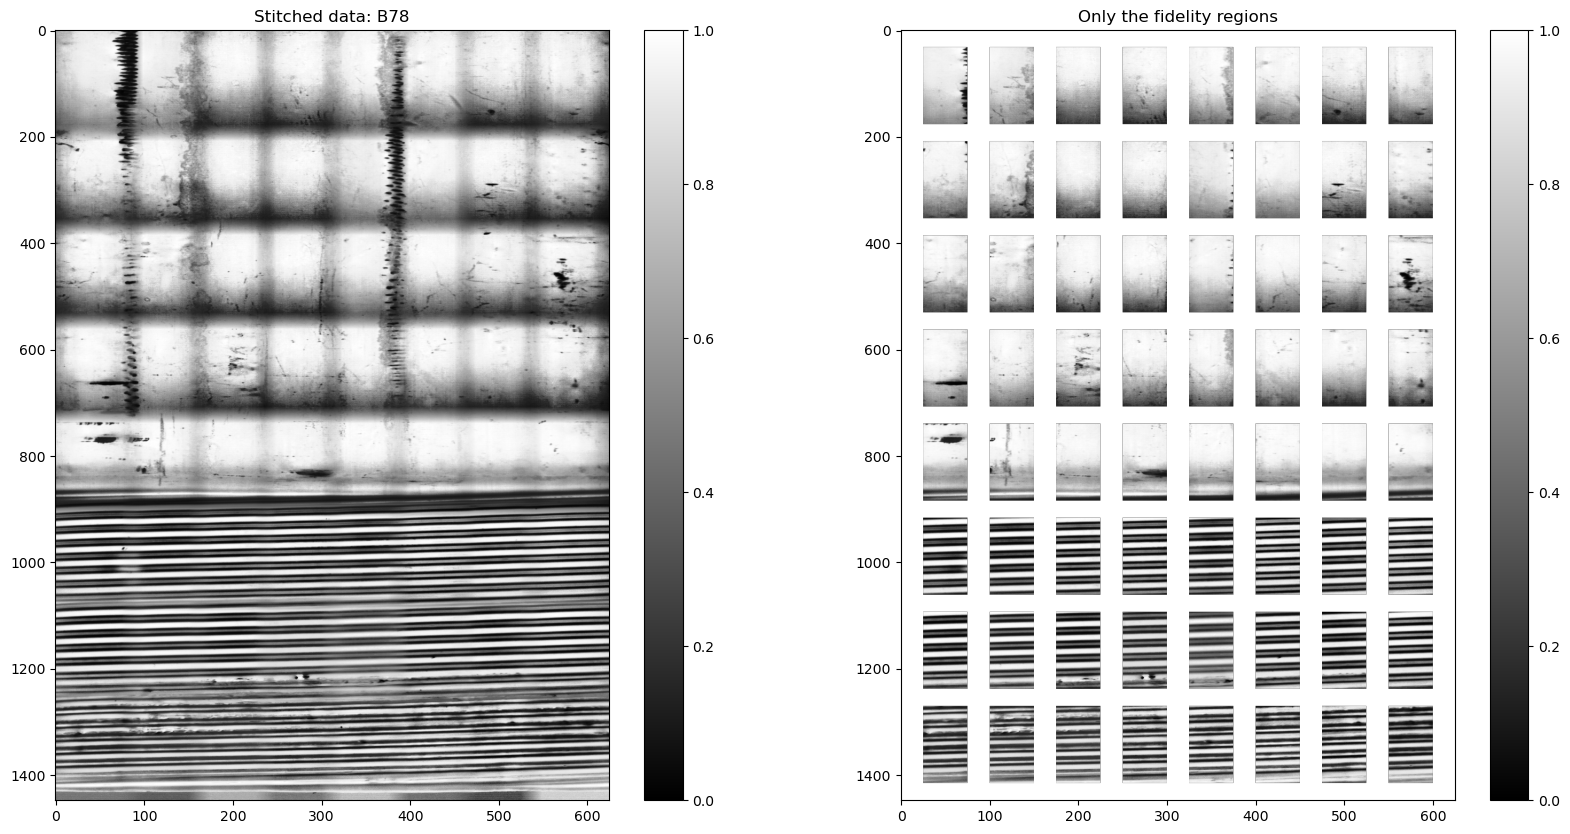

In [14]:
this_frame = 40#0

# Stitcher results
#fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# Reco: overlapped area = sum of the pixel values
# --> consequently, the values in the overlap is way too large compared to the actual values
# --> work-around solution: clip 
im1= ax1.imshow(output_arr[:, :, this_frame], cmap=plt.cm.gray, aspect=0.6)
ax1.set_title(f'Stitched data: B{screwNo}')
fig.colorbar(im1, ax=ax1)

# Only the fidelity regions 
im2=ax2.imshow((fid_map* output_arr)[..., this_frame], cmap=plt.cm.gray, aspect=0.6)
ax2.set_title('Only the fidelity regions')
fig.colorbar(im2, ax=ax2)

# # Trimmed
# y_max = 1600
# im3=ax3.imshow(im_trimmed[:y_max, :, this_frame], cmap=plt.cm.gray)
# ax3.set_title('Trimmed')
# fig.colorbar(im3, ax=ax3)

#plt.savefig('merging_example_B78_post.png')

plt.show()

In [ ]:
raise ValueError('Stop!')
#W = stitcher.weights()

In [ ]:
fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9) = plt.subplots(1, 9, figsize=(20, 8))

pos = (0, 1)
Wy, Wx = stitcher.linear_weights(seg_shape[:2])
ovl_mask = stitcher.ovl_mask(pos)

ax1.imshow(stitcher.weights(pos))
ax2.imshow(ovl_mask.real)
ax3.imshow(ovl_mask.imag)

#ax4.imshow(np.abs(stitcher.ovl_map))
ax4.imshow(Wy*Wx)
ax5.imshow(Wy)
ax6.imshow(Wx)

#y_indices = np.array(np.logical_and((np.abs(ovl_mask) <= 1.0), (ovl_mask.real) > 0.0))
y_indices = np.array(ovl_mask.real < 1.0)
Wy_new = np.copy(Wy)
Wy_new[y_indices]= 1.0

x_indices = np.array(ovl_mask.imag < 1.0)
Wx_new = np.copy(Wx)
Wx_new[x_indices]= 1.0

ax7.imshow(Wy_new)
ax8.imshow(Wx_new)
ax9.imshow(Wy_new* Wx_new)

In [ ]:
# ---> For saving the plots
%matplotlib inline
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

trimmed = False

# Show the stitched data
if trimmed == True:
    ax.imshow(im_trimmed[:y_max, :, 40], cmap=plt.cm.gray, aspect=0.35)
    ax.set_xticks(int(fid_width/2) + fid_width* np.arange(0, numsegs_per_col))
    # tick labels as e.g. ['0°', '45°', ...]
    xticks_labels = np.linspace(0, 315, numsegs_per_col, dtype=int).astype(str) + np.repeat('°', numsegs_per_col) 
# Show only the array formatting of the data
else:
    ax.imshow(
        output_arr[:, :, this_frame], 
        vmin=0.0, vmax=1.0, 
        cmap=plt.cm.gray, aspect=0.5,
             )
    # Ticks
    correct_width = 8*ThremoDataPreprocessing.surface_projection(angle_start=67.5, angle_end=135-22.5) #-> correct width for 360deg
    xtick_offset = int((output_arr.shape[1] - correct_width)/2)
    xticks = xtick_offset + stitcher.stepsize_width* np.arange(0, numsegs_per_col+1)
    # tick labels as e.g. ['0°', '45°', ...]
    xticks_labels = np.linspace(0, 360, numsegs_per_col+1, dtype=int).astype(str) + np.repeat('°', numsegs_per_col+1) 
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticks_labels)

# Axis setting
#ax.set_axis_off()
ax.set_xlabel('Rotation')
ax.set_title(f'B{screwNo}, post-damage, {screw_part}')

# y --> empty
ax.get_yaxis().set_visible(False)
plt.tight_layout()
# if trimmed == False:
#     plt.savefig(f'B{screwNo}_stitched_post.png', dpi=250)
plt.show()

In [ ]:
# Correcting the area of x-overlap
length = output_arr.shape[1] - 50 # in pixels
target = 200* 360/180 # in pixels
excess = (length-target)/7 # per image
excess_deg = excess/200* 180
print(excess)
print(excess_deg)

In [ ]:
output_arr.shape

In [ ]:
stitcher.fidelity_map.shape

In [ ]:
(stitcher.numsegs_per_row - 1) * stitcher.stepsize_height + stitcher.seg_height

In [ ]:
(stitcher.numsegs_per_col - 1) * stitcher.stepsize_width + stitcher.seg_width

In [ ]:
stitcher.seg_width

In [ ]:
76*8